## Data Processing

We now have physical data. How the radiative transfer code works is that a set of parameters, including the log stellar mass, log dust mass, etc, are fed to a SKIRT model, which produces a .h5 file containing values for flux, half-radius, and sersic index against wavelength: at each angle of inclination. There're 20 angles of inclination that the model considers.

I've got 6 .h5 files. Each file was given different values for log stellar and dust mass. My objective here is to merge all of the data in those files into one csv. My intention is to feed the resulting csv into the model we've developed previously, to see if it can predict the same values that the classical model does.

I'll start with module importation.

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [67]:
def read_params(filename: str, filepath: str = '../../../data/radiative_transfer/Testing/'):
    """
    Reads parameters from a specified file and returns them as a dictionary.

    The function reads a text file where each line contains a parameter in the format:
    `key = value # optional comment`. The function parses these lines to extract the keys 
    and values, ignoring any text following a '#' as a comment.

    Parameters:
    - file (str, optional): The path to the file containing the parameters. 
    Default is '../../data/radiative_transfer/input/parameters.txt'.

    Returns:
    - dict: A dictionary where each key-value pair corresponds to a parameter 
    and its respective value. If a line contains a comma-separated list of values, 
    they are converted to a NumPy array. If the value is a single number (except for 
    the 'theta' parameter), it is converted to a float.

    Note:
    - This function assumes that each parameter is defined only once in the file.
    - The function is designed to handle special cases where the value is a list 
    (converted to a NumPy array) or a single float. The exception is the 'theta' 
    parameter, which is always treated as a NumPy array.
    """

    lines = open(filepath+filename, 'r').readlines()

    keys = []
    values = []
    for i in range(len(lines)):
        
        line_i = lines[i]
        line1 = line_i.split('\n')[0]
        line2 = line1.split('#')[0]
        line3 = line2.split('=')
        line4 = []
        for j in range(len(line3)):
            line4.append( line3[j].strip(' ') )
        
        if len(line4) == 2:
            keys.append(line4[0])
            line5 = line4[1].split(', ')
            line5 = np.array(line5).astype(float)
            if len(line5) == 1 and line4[0]!='theta':
                line5 = line5[0]
            values.append(line5)

    table = dict(zip(keys, values) )
    return table


In [68]:
def read_h5_file(filename: str, thetas, log_mstar, log_mdust_over_mstar, filepath: str = '../../../data/radiative_transfer/Testing/'):
    """
    Reads HDF5 files and compiles data into a single DataFrame with additional parameters.

    Parameters:
    - filename (str): The name of the HDF5 file to be read.
    - thetas (array-like): An array of viewing angles corresponding to each entry in the HDF5 file.
    - log_mstar (float): Logarithmic value of stellar mass.
    - log_mdust_over_mstar (float): Logarithmic value of the dust mass over stellar mass ratio.
    - filepath (str, optional): Path to the directory containing the HDF5 file. Defaults to '../../data/radiative_transfer/output/'.

    Returns:
    - pd.DataFrame: A DataFrame containing wavelength, flux, half-light radius, Sersic index, viewing angle, logarithm of stellar mass, and logarithm of dust mass over stellar mass ratio.

    This function iterates over keys in the HDF5 file, extracts relevant data, and compiles it into a comprehensive DataFrame, adding constant parameters for stellar mass and dust mass ratios.
    """
    
    filepath += filename 
    print(filepath)

    # Finding hdf keys
    hdf_keys = np.array([])
    with pd.HDFStore(filepath, 'r') as hdf:
        hdf_keys = np.append(hdf_keys, hdf.keys())

    big_df = pd.DataFrame(columns=['wvl', 'flux', 'r', 'n', 'theta', 'log_mstar', 'log_mdust_over_mstar'])

    for i in range(len(hdf_keys)):
        table = pd.read_hdf(filepath, hdf_keys[i]) # Face-on view
        wvl = table['wvl'].to_numpy() # rest-frame wavelength [micron]
        flux = table['flux'].to_numpy() # flux [W/m^2]
        r = table['r'].to_numpy() # half-light radius [kpc]
        n = table['n'].to_numpy() # Sersic index
        theta = np.array([thetas[i] for _ in range(len(wvl))]) # viewing angle [degrees]

        df = pd.DataFrame({'wvl': wvl, 'flux': flux, 'r': r, 'n': n, 'theta': theta})
        big_df = pd.concat([big_df, df], ignore_index=True)

    big_df['log_mstar'] = np.array([log_mstar for _ in range(len(big_df))])
    big_df['log_mdust_over_mstar'] = np.array([log_mdust_over_mstar for _ in range(len(big_df))])

    return big_df.reset_index(drop=True)


In [69]:
def read_parameter_files(filenames: list, filepath: str = ""):
    """
    Reads multiple parameter files and extracts key information.

    Parameters:
    - filenames (list): A list of filenames for the parameter files to be read.
    - filepath (str, optional): Path to the directory containing the parameter files. Defaults to "../../data/radiative_transfer/input/".

    Returns:
    - tuple: A tuple containing three arrays - list_log_mstar, list_log_mdust_over_mstar, and list_theta. 
      - list_log_mstar (numpy.ndarray): Array of logarithmic stellar mass values.
      - list_log_mdust_over_mstar (numpy.ndarray): Array of logarithmic dust mass over stellar mass ratio values.
      - list_theta (numpy.ndarray): Array of viewing angles.

    The function iterates over each file, reads its parameters, and compiles key data into arrays for further processing.
    """

    list_log_mstar = np.array([])
    list_log_mdust = np.array([])
    list_theta = np.array([])

    for filename in filenames:
        table = read_params(filename, filepath)
        list_log_mstar = np.append(list_log_mstar, table['logMstar'])
        list_log_mdust = np.append(list_log_mdust, table['logMdust'])
        list_theta = np.append(list_theta, table['theta'])

    list_log_mdust_over_mstar = list_log_mdust - list_log_mstar

    return list_log_mstar, list_log_mdust_over_mstar, list_theta


In [70]:
#obtaining logs of stellar mass, and ratio of dust to stellar mass
parameter_files = [f"parameters{i}.txt" for i in range(4, 5)]
h5_files = [f"data{i}.h5" for i in range(4, 5)]
list_log_mstar, list_log_mdust_over_mstar, list_theta = read_parameter_files(parameter_files)


In [71]:
final_df = pd.DataFrame(columns=["theta", "wvl", "flux", "r", "n", "log_mstar", "log_mdust_over_mstar"])
for i in range(len(h5_files)):
    output = read_h5_file(h5_files[i], list_theta, list_log_mstar[i], list_log_mdust_over_mstar[i])
    # output.to_csv(f"../../data/radiative_transfer/output/data{i+1}.csv", index=False)
    final_df = pd.concat([final_df, output], ignore_index=True)

final_df.to_csv("../../radiative_transfer/Testing/data.csv", index=False)


../../../data/radiative_transfer/Testing/data4.h5


C:\Users\joshu\AppData\Local\Temp\ipykernel_15228\1139448441.py:37: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  big_df = pd.concat([big_df, df], ignore_index=True)
C:\Users\joshu\AppData\Local\Temp\ipykernel_15228\18229771.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_df = pd.concat([final_df, output], ignore_index=True)


In [142]:
df = pd.read_csv("../../radiative_transfer/Testing/data.csv")

print(df.iloc[0:113,:])

df = df.sort_values(by=['wvl'])



     theta          wvl          flux         r         n  log_mstar  \
0     0.00     0.090000  4.825060e-12  9.323390  0.200000      11.17   
1     0.00     0.098880  2.237217e-11  9.012391  0.200000      11.17   
2     0.00     0.108636  3.064999e-11  8.792406  0.200000      11.17   
3     0.00     0.119355  2.741216e-11  8.536463  0.200000      11.17   
4     0.00     0.131132  3.298866e-11  8.439763  0.200000      11.17   
..     ...          ...           ...       ...       ...        ...   
109   0.00   754.051986  1.969750e-13  2.443113  0.999513      11.17   
110   0.00   828.452333  1.343482e-13  2.431296  0.992688      11.17   
111   0.00   910.193569  9.208827e-14  2.404366  1.002528      11.17   
112   0.00  1000.000000  5.520550e-14  2.413462  0.969320      11.17   
113  18.67     0.090000  4.506910e-12  9.396213  0.200000      11.17   

     log_mdust_over_mstar  
0                   -2.79  
1                   -2.79  
2                   -2.79  
3                   -2.

Text(0, 0.5, 'Flux')

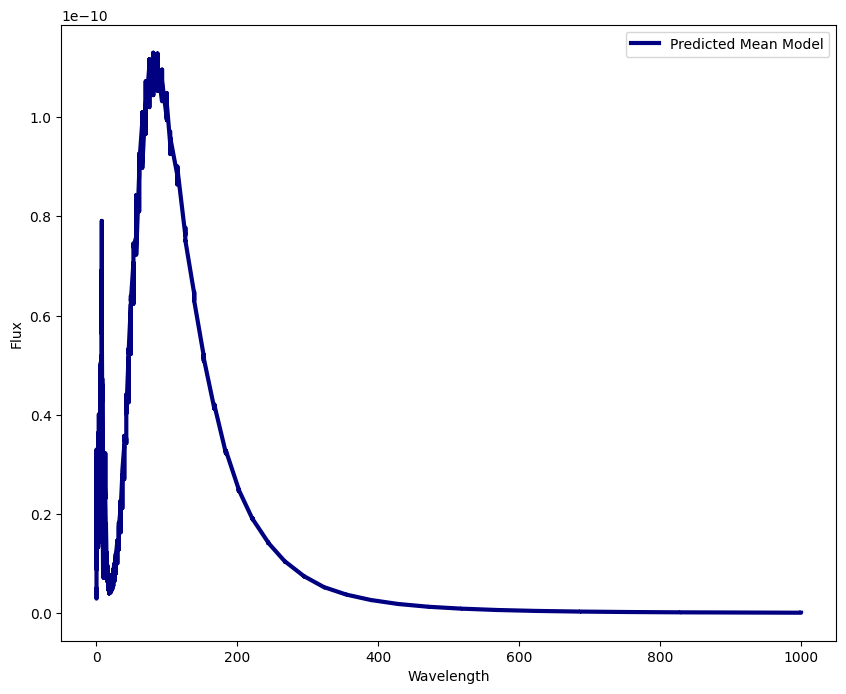

In [73]:
plt.figure(figsize=(10,8))
plt.plot(df['wvl'],df['flux'],color='navy',lw=3,label='Predicted Mean Model')
plt.legend()
plt.xlabel('Wavelength')    
plt.ylabel('Flux')


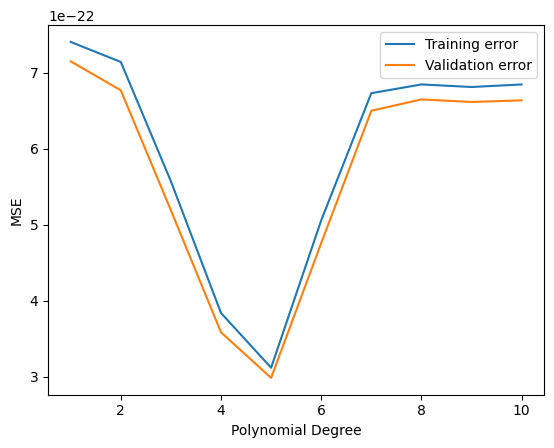

In [78]:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

# Assuming 'df' is your DataFrame

X_train, X_val, y_train, y_val = train_test_split(df['wvl'], df['flux'], test_size=0.2, random_state=42)

max_degree = 10  # You can adjust this
train_errors, val_errors = [], []

for degree in range(1, max_degree + 1):
    poly_features = PolynomialFeatures(degree=degree)
    X_train_poly = poly_features.fit_transform(np.array(X_train).reshape(-1, 1))
    X_val_poly = poly_features.transform(np.array(X_val).reshape(-1, 1))

    model = LinearRegression()
    model.fit(X_train_poly, y_train)

    y_train_predict = model.predict(X_train_poly)
    y_val_predict = model.predict(X_val_poly)

    train_errors.append(mean_squared_error(y_train, y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))

plt.plot(range(1, max_degree + 1), train_errors, label='Training error')
plt.plot(range(1, max_degree + 1), val_errors, label='Validation error')
plt.xlabel('Polynomial Degree')
plt.ylabel('MSE')
plt.legend()
plt.show()


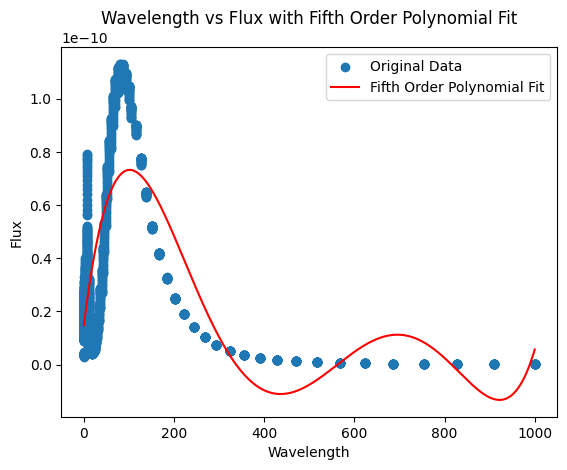

In [79]:
# Assuming 'df' is your DataFrame
wavelength = df['wvl']
flux = df['flux']

# Fit a fifth-order polynomial
coefficients = np.polyfit(wavelength, flux, 5)
polynomial = np.poly1d(coefficients)

# Generate values for the polynomial fit curve
wavelength_fit = np.linspace(min(wavelength), max(wavelength), 1000)
flux_fit = polynomial(wavelength_fit)

# Plot the original data and the polynomial fit
plt.scatter(wavelength, flux, label='Original Data')
plt.plot(wavelength_fit, flux_fit, color='red', label='Fifth Order Polynomial Fit')
plt.xlabel('Wavelength')
plt.ylabel('Flux')
plt.legend()
plt.title('Wavelength vs Flux with Fifth Order Polynomial Fit')
plt.show()


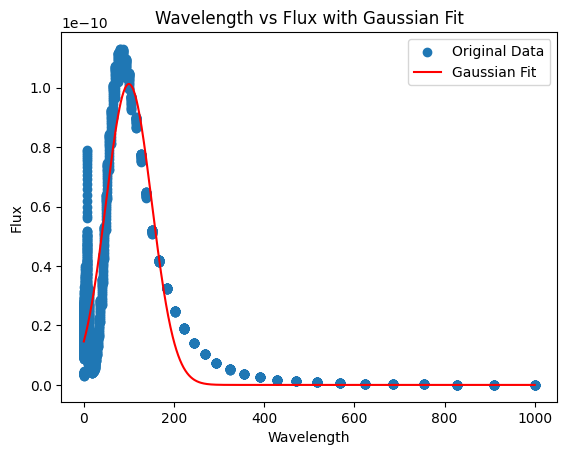

In [80]:
from scipy.optimize import curve_fit

# Assuming 'df' is your DataFrame
wavelength = df['wvl']
flux = df['flux']

# Define the Gaussian function
def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean) / (2 * stddev))**2)

# Initial guess for the parameters
initial_guess = [max(flux), np.mean(wavelength), np.std(wavelength)]

# Fit the Gaussian function to the data
params, covariance = curve_fit(gaussian, wavelength, flux, p0=initial_guess)

# Extract the fitted parameters
amplitude, mean, stddev = params

# Generate values for the Gaussian fit curve
wavelength_fit = np.linspace(min(wavelength), max(wavelength), 1000)
flux_fit = gaussian(wavelength_fit, amplitude, mean, stddev)

# Plot the original data and the Gaussian fit
plt.scatter(wavelength, flux, label='Original Data')
plt.plot(wavelength_fit, flux_fit, color='red', label='Gaussian Fit')
plt.xlabel('Wavelength')
plt.ylabel('Flux')
plt.legend()
plt.title('Wavelength vs Flux with Gaussian Fit')
plt.show()


Amplitude: 1.0123862536287287e-10
Mean: 99.98401834695775
Standard Deviation: 35.90578269879086


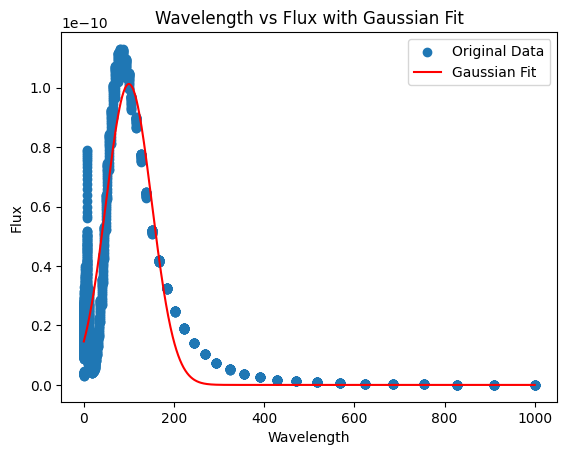

In [81]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Assuming 'df' is your DataFrame
wavelength = df['wvl']
flux = df['flux']

# Define the Gaussian function
def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean) / (2 * stddev))**2)

# Initial guess for the parameters
initial_guess = [max(flux), np.mean(wavelength), np.std(wavelength)]

# Fit the Gaussian function to the data
params, covariance = curve_fit(gaussian, wavelength, flux, p0=initial_guess)

# Extract the fitted parameters
amplitude, mean, stddev = params

# Print or return the coefficients
print("Amplitude:", amplitude)
print("Mean:", mean)
print("Standard Deviation:", stddev)

# Generate values for the Gaussian fit curve
wavelength_fit = np.linspace(min(wavelength), max(wavelength), 1000)
flux_fit = gaussian(wavelength_fit, amplitude, mean, stddev)

# Plot the original data and the Gaussian fit
plt.scatter(wavelength, flux, label='Original Data')
plt.plot(wavelength_fit, flux_fit, color='red', label='Gaussian Fit')
plt.xlabel('Wavelength')
plt.ylabel('Flux')
plt.legend()
plt.title('Wavelength vs Flux with Gaussian Fit')
plt.show()


c:\Users\joshu\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Amplitude 1: 1.0123833416687417e-10
Mean 1: 99.9842651757076
Standard Deviation 1: -35.90599483922649
Amplitude 2: 4.955421513349164e-10
Mean 2: 132541.37907718358
Standard Deviation 2: 10850.850981837051


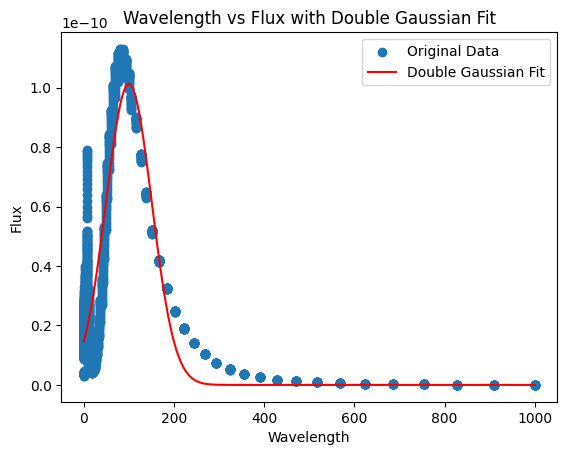

In [82]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Assuming 'df' is your DataFrame
wavelength = df['wvl']
flux = df['flux']

# Define a sum of two Gaussians function
def double_gaussian(x, amplitude1, mean1, stddev1, amplitude2, mean2, stddev2):
    return (amplitude1 * np.exp(-((x - mean1) / (2 * stddev1))**2) +
            amplitude2 * np.exp(-((x - mean2) / (2 * stddev2))**2))

# Initial guess for the parameters
initial_guess = [max(flux), np.mean(wavelength), np.std(wavelength),
                  max(flux) / 2, np.mean(wavelength) + 10, np.std(wavelength)]

# Fit the sum of two Gaussians function to the data
params, covariance = curve_fit(double_gaussian, wavelength, flux, p0=initial_guess)

# Extract the fitted parameters
amplitude1, mean1, stddev1, amplitude2, mean2, stddev2 = params

# Print or return the coefficients
print("Amplitude 1:", amplitude1)
print("Mean 1:", mean1)
print("Standard Deviation 1:", stddev1)
print("Amplitude 2:", amplitude2)
print("Mean 2:", mean2)
print("Standard Deviation 2:", stddev2)

# Generate values for the double Gaussian fit curve
wavelength_fit = np.linspace(min(wavelength), max(wavelength), 1000)
flux_fit = double_gaussian(wavelength_fit, amplitude1, mean1, stddev1, amplitude2, mean2, stddev2)

# Plot the original data and the double Gaussian fit
plt.scatter(wavelength, flux, label='Original Data')
plt.plot(wavelength_fit, flux_fit, color='red', label='Double Gaussian Fit')
plt.xlabel('Wavelength')
plt.ylabel('Flux')
plt.legend()
plt.title('Wavelength vs Flux with Double Gaussian Fit')
plt.show()


Amplitude 1: 1.1341588731585893e-10
Mean 1: 96.37856038907817
Standard Deviation 1: -27.339537212171464
Amplitude 2: 7.493031630576784e-10
Mean 2: 51530.913291999306
Standard Deviation 2: 1770.0308245948008


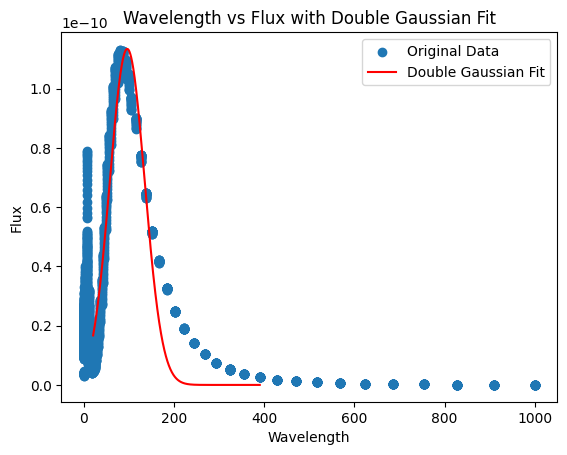

In [83]:

# Assuming 'df' is your DataFrame
wavelength = df['wvl']
flux = df['flux']

# Define a sum of two Gaussians function
def double_gaussian(x, amplitude1, mean1, stddev1, amplitude2, mean2, stddev2):
    return (amplitude1 * np.exp(-((x - mean1) / (2 * stddev1))**2) +
            amplitude2 * np.exp(-((x - mean2) / (2 * stddev2))**2))

# Specify the range for fitting
fit_range = (20, 400)  # Adjust the range as needed

# Filter data within the specified range
mask = (wavelength >= fit_range[0]) & (wavelength <= fit_range[1])
wavelength_fit = wavelength[mask]
flux_fit_data = flux[mask]

# Initial guess for the parameters
initial_guess = [max(flux_fit_data), np.mean(wavelength_fit), np.std(wavelength_fit),
                  max(flux_fit_data) / 2, np.mean(wavelength_fit) + 10, np.std(wavelength_fit)]

# Fit the sum of two Gaussians function to the filtered data
params, covariance = curve_fit(double_gaussian, wavelength_fit, flux_fit_data, p0=initial_guess)

# Extract the fitted parameters
amplitude1, mean1, stddev1, amplitude2, mean2, stddev2 = params

# Print or return the coefficients
print("Amplitude 1:", amplitude1)
print("Mean 1:", mean1)
print("Standard Deviation 1:", stddev1)
print("Amplitude 2:", amplitude2)
print("Mean 2:", mean2)
print("Standard Deviation 2:", stddev2)

# Generate values for the double Gaussian fit curve
wavelength_fit_curve = np.linspace(min(wavelength_fit), max(wavelength_fit), 1000)
flux_fit_curve = double_gaussian(wavelength_fit_curve, amplitude1, mean1, stddev1, amplitude2, mean2, stddev2)

# Plot the original data and the double Gaussian fit
plt.scatter(wavelength, flux, label='Original Data')
plt.plot(wavelength_fit_curve, flux_fit_curve, color='red', label='Double Gaussian Fit')
plt.xlabel('Wavelength')
plt.ylabel('Flux')
plt.legend()
plt.title('Wavelength vs Flux with Double Gaussian Fit')
plt.show()


Amplitude: 1.465539059938331e-10
Center: 95.61694628310414
Sigma (Gaussian width): 32.42381824202949
Gamma (Lorentzian width): 10.932438513357551


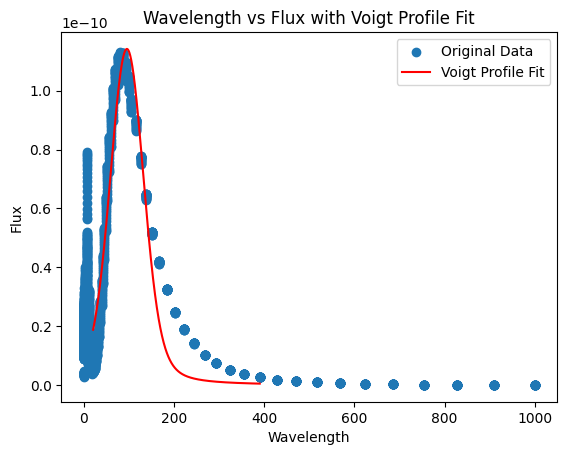

In [85]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import wofz

# Assuming 'df' is your DataFrame
wavelength = df['wvl']
flux = df['flux']

# Define the Voigt profile function
def voigt(x, amplitude, center, sigma, gamma):
    z = ((x - center) + 1j * gamma) / (sigma * np.sqrt(2))
    return amplitude * np.real(wofz(z))

# Specify the range for fitting
fit_range = (20, 400)  # Adjust the range as needed

# Filter data within the specified range
mask = (wavelength >= fit_range[0]) & (wavelength <= fit_range[1])
wavelength_fit = wavelength[mask]
flux_fit_data = flux[mask]

# Initial guess for the parameters
initial_guess = [max(flux_fit_data), np.mean(wavelength_fit), np.std(wavelength_fit) / 2, np.std(wavelength_fit) / 2]

# Fit the Voigt profile function to the filtered data
params, covariance = curve_fit(voigt, wavelength_fit, flux_fit_data, p0=initial_guess)

# Extract the fitted parameters
amplitude, center, sigma, gamma = params

# Print or return the coefficients
print("Amplitude:", amplitude)
print("Center:", center)
print("Sigma (Gaussian width):", sigma)
print("Gamma (Lorentzian width):", gamma)

# Generate values for the Voigt profile fit curve
wavelength_fit_curve = np.linspace(min(wavelength_fit), max(wavelength_fit), 1000)
flux_fit_curve = voigt(wavelength_fit_curve, amplitude, center, sigma, gamma)

# Plot the original data and the Voigt profile fit
plt.scatter(wavelength, flux, label='Original Data')
plt.plot(wavelength_fit_curve, flux_fit_curve, color='red', label='Voigt Profile Fit')
plt.xlabel('Wavelength')
plt.ylabel('Flux')
plt.legend()
plt.title('Wavelength vs Flux with Voigt Profile Fit')
plt.show()


Amplitude: 1.4656886729489996e-10
Center: 95.61732414487722
Sigma (Gaussian width): 32.42129039855899
Gamma (Lorentzian width): 10.935901287075069


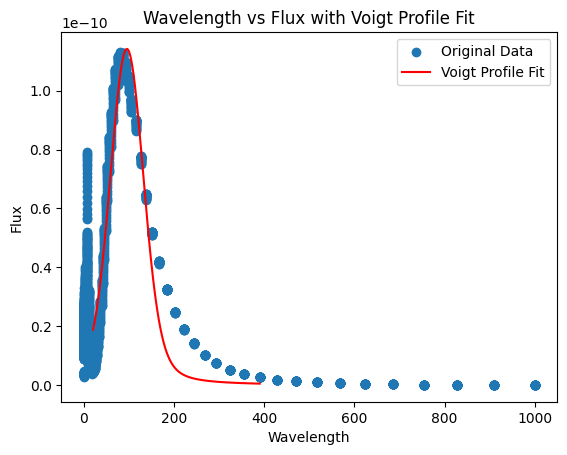

In [92]:

# Assuming 'df' is your DataFrame
wavelength = df['wvl']
flux = df['flux']

# Define the Voigt profile function
def voigt(x, amplitude, center, sigma, gamma):
    z = ((x - center) + 1j * gamma) / (sigma * np.sqrt(2))
    return amplitude * np.real(wofz(z))

# Specify the range for fitting
fit_range = (20, 400)  # Adjust the range as needed

# Filter data within the specified range
mask = (wavelength >= fit_range[0]) & (wavelength <= fit_range[1])
wavelength_fit = wavelength[mask]
flux_fit_data = flux[mask]

# Initial guess for the parameters
initial_guess = [max(flux_fit_data), np.mean(wavelength_fit), np.std(wavelength_fit), 100]

# Fit the Voigt profile function to the filtered data
params, covariance = curve_fit(voigt, wavelength_fit, flux_fit_data, p0=initial_guess)

# Extract the fitted parameters
amplitude, center, sigma, gamma = params

# Print or return the coefficients
print("Amplitude:", amplitude)
print("Center:", center)
print("Sigma (Gaussian width):", sigma)
print("Gamma (Lorentzian width):", gamma)

# Generate values for the Voigt profile fit curve
wavelength_fit_curve = np.linspace(min(wavelength_fit), max(wavelength_fit), 1000)
flux_fit_curve = voigt(wavelength_fit_curve, amplitude, center, sigma, gamma)

# Plot the original data and the Voigt profile fit
plt.scatter(wavelength, flux, label='Original Data')
plt.plot(wavelength_fit_curve, flux_fit_curve, color='red', label='Voigt Profile Fit')
plt.xlabel('Wavelength')
plt.ylabel('Flux')
plt.legend()
plt.title('Wavelength vs Flux with Voigt Profile Fit')
plt.show()


Amplitude: 1.2614867894709053e-08
Mean: 49.395277047192636
Standard Deviation: 83.87692231683886
Alpha (Skewness): 5.115912745716635


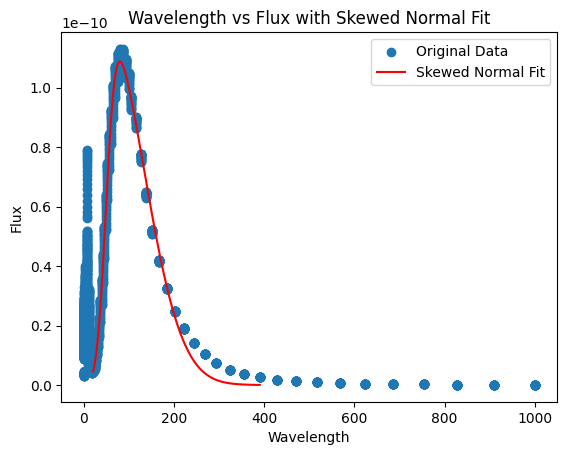

In [94]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skewnorm

# Assuming 'df' is your DataFrame
wavelength = df['wvl']
flux = df['flux']

# Define the skewed normal distribution function
def skewed_normal(x, amplitude, mean, std, alpha):
    return amplitude * skewnorm.pdf(x, alpha, loc=mean, scale=std)

# Specify the range for fitting
fit_range = (20, 400)  # Adjust the range as needed

# Filter data within the specified range
mask = (wavelength >= fit_range[0]) & (wavelength <= fit_range[1])
wavelength_fit = wavelength[mask]
flux_fit_data = flux[mask]

# Initial guess for the parameters
initial_guess = [max(flux_fit_data), np.mean(wavelength_fit), np.std(wavelength_fit), 0.5]

# Fit the skewed normal distribution function to the filtered data
params, covariance = curve_fit(skewed_normal, wavelength_fit, flux_fit_data, p0=initial_guess)

# Extract the fitted parameters
amplitude, mean, std, alpha = params

# Print or return the coefficients
print("Amplitude:", amplitude)
print("Mean:", mean)
print("Standard Deviation:", std)
print("Alpha (Skewness):", alpha)

# Generate values for the skewed normal fit curve
wavelength_fit_curve = np.linspace(min(wavelength_fit), max(wavelength_fit), 1000)
flux_fit_curve = skewed_normal(wavelength_fit_curve, amplitude, mean, std, alpha)

# Plot the original data and the skewed normal fit
plt.scatter(wavelength, flux, label='Original Data')
plt.plot(wavelength_fit_curve, flux_fit_curve, color='red', label='Skewed Normal Fit')
plt.xlabel('Wavelength')
plt.ylabel('Flux')
plt.legend()
plt.title('Wavelength vs Flux with Skewed Normal Fit')
plt.show()


Amplitude: 3298.3503118841113
Mean: 9.81103173846604
Standard Deviation: 2420.965049267182
Alpha (Skewness): 51.16294602171365


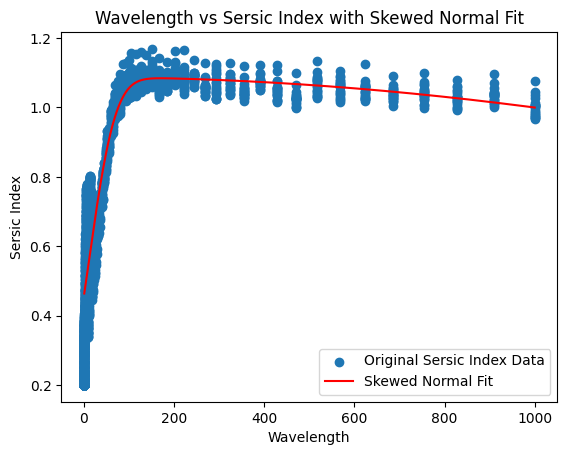

In [98]:

# Assuming 'df' is your DataFrame
wavelength = df['wvl']
n = df['n']

# Define the skewed normal distribution function
def skewed_normal(x, amplitude, mean, std, alpha):
    return amplitude * skewnorm.pdf(x, alpha, loc=mean, scale=std)

# Specify the range for fitting
fit_range = (1, 1000)  # Adjust the range as needed

# Filter data within the specified range
mask = (wavelength >= fit_range[0]) & (wavelength <= fit_range[1])
wavelength_fit = wavelength[mask]
n_fit_data = n[mask]

# Initial guess for the parameters
initial_guess = [max(n_fit_data), np.mean(wavelength_fit), np.std(wavelength_fit), 0.5]

# Fit the skewed normal distribution function to the filtered data
params, covariance = curve_fit(skewed_normal, wavelength_fit, n_fit_data, p0=initial_guess)

# Extract the fitted parameters
amplitude, mean, std, alpha = params

# Print or return the coefficients
print("Amplitude:", amplitude)
print("Mean:", mean)
print("Standard Deviation:", std)
print("Alpha (Skewness):", alpha)

# Generate values for the skewed normal fit curve
wavelength_fit_curve = np.linspace(min(wavelength_fit), max(wavelength_fit), 1000)
n_fit_curve = skewed_normal(wavelength_fit_curve, amplitude, mean, std, alpha)

# Plot the original Sersic index data and the skewed normal fit
plt.scatter(wavelength, n, label='Original Sersic Index Data')
plt.plot(wavelength_fit_curve, n_fit_curve, color='red', label='Skewed Normal Fit')
plt.xlabel('Wavelength')
plt.ylabel('Sersic Index')
plt.legend()
plt.title('Wavelength vs Sersic Index with Skewed Normal Fit')
plt.show()


In [104]:
df['r']


0        9.323390
1582     9.682683
1921    10.645300
1469     9.440992
113      9.396213
          ...    
1694     2.425162
1807     2.420063
1920     2.427273
1016     2.590894
2259     2.454522
Name: r, Length: 2260, dtype: float64

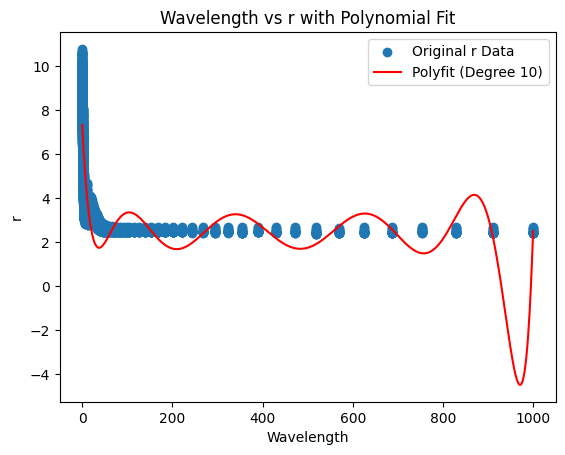

Polynomial Coefficients: [ 7.47463885e-25 -3.65412171e-21  7.60881061e-18 -8.80371527e-15
  6.19221946e-12 -2.72172833e-09  7.40212311e-07 -1.19065911e-04
  1.03239821e-02 -4.03902802e-01  7.37659838e+00]


In [107]:

# Assuming 'df' is your DataFrame
wavelength = df['wvl']
r = df['r']

# Degree of the polynomial (you can adjust this)
degree = 10

# Perform polynomial fit
coefficients = np.polyfit(wavelength, r, degree)

# Generate values for the fitted polynomial curve
wavelength_fit_curve = np.linspace(min(wavelength), max(wavelength), 1000)
r_fit_curve = np.polyval(coefficients, wavelength_fit_curve)

# Plot the original 'r' data and the polynomial fit
plt.scatter(wavelength, r, label='Original r Data')
plt.plot(wavelength_fit_curve, r_fit_curve, color='red', label=f'Polyfit (Degree {degree})')
plt.xlabel('Wavelength')
plt.ylabel('r')
plt.legend()
plt.title('Wavelength vs r with Polynomial Fit')
plt.show()

# Print or return the coefficients of the polynomial fit
print("Polynomial Coefficients:", coefficients)


Coefficient 'a': 7.007469324714949
Coefficient 'b': 0.5339916746071709
Coefficient 'c': 2.8169358241577225


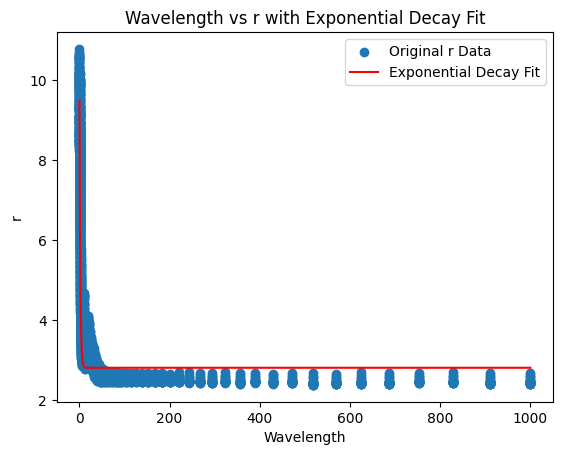

In [129]:
# Assuming 'df' is your DataFrame
wavelength = df['wvl']
r = df['r']

# Define the exponential decay function
def exponential_decay(x, a, b, c):
    return a * np.exp(-b * x) + c

# Specify the range for fitting
fit_range = (0, 1000)  # Adjust the range as needed

# Filter data within the specified range
mask = (wavelength >= fit_range[0]) & (wavelength <= fit_range[1])
wavelength_fit = wavelength[mask]
r_fit_data = r[mask]

# Initial guess for the parameters
initial_guess = [max(r_fit_data), 0.001, min(r_fit_data)]

# Fit the exponential decay function to the filtered data
params, covariance = curve_fit(exponential_decay, wavelength_fit, r_fit_data, p0=initial_guess)

# Extract the fitted parameters
a, b, c = params

# Print or return the coefficients
print("Coefficient 'a':", a)
print("Coefficient 'b':", b)
print("Coefficient 'c':", c)

# Generate values for the exponential decay fit curve
wavelength_fit_curve = np.linspace(min(wavelength_fit), max(wavelength_fit), 1000)
r_fit_curve = exponential_decay(wavelength_fit_curve, a, b, c)

# Plot the original 'r' data and the exponential decay fit
plt.scatter(wavelength, r, label='Original r Data')
plt.plot(wavelength_fit_curve, r_fit_curve, color='red', label='Exponential Decay Fit')
plt.xlabel('Wavelength')
plt.ylabel('r')
plt.legend()
plt.title('Wavelength vs r with Exponential Decay Fit')
plt.show()


Coefficient 'a': 6.2657852667089085
Coefficient 'n': 0.2235945399864391


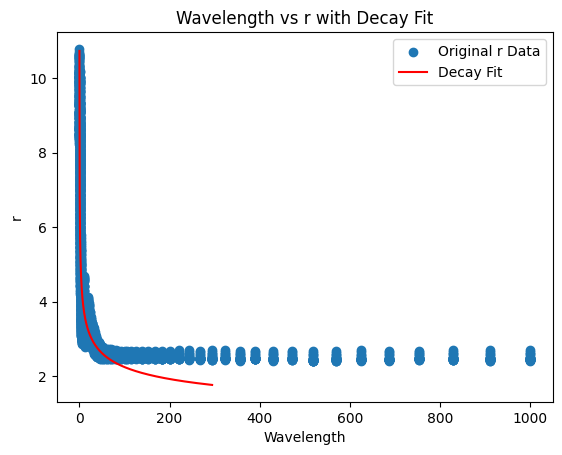

In [126]:
# Assuming 'df' is your DataFrame
wavelength = df['wvl']
r = df['r']

# Define the decay function
def decay_function(x, a, n):
    return a / (x**n)

# Specify the range for fitting
fit_range = (0, 300)  # Adjust the range as needed

# Filter data within the specified range
mask = (wavelength >= fit_range[0]) & (wavelength <= fit_range[1])
wavelength_fit = wavelength[mask]
r_fit_data = r[mask]

# Initial guess for the parameters
initial_guess = [max(r_fit_data), 2.0]  # You may need to adjust the initial guess

# Fit the decay function to the filtered data
params, covariance = curve_fit(decay_function, wavelength_fit, r_fit_data, p0=initial_guess)

# Extract the fitted parameters
a, n = params

# Print or return the coefficients
print("Coefficient 'a':", a)
print("Coefficient 'n':", n)

# Generate values for the decay fit curve
wavelength_fit_curve = np.linspace(min(wavelength_fit), max(wavelength_fit), 1000)
r_fit_curve = decay_function(wavelength_fit_curve, a, n)

# Plot the original 'r' data and the decay fit
plt.scatter(wavelength, r, label='Original r Data')
plt.plot(wavelength_fit_curve, r_fit_curve, color='red', label='Decay Fit')
plt.xlabel('Wavelength')
plt.ylabel('r')
plt.legend()
plt.title('Wavelength vs r with Decay Fit')
plt.show()


Coefficient 'a': 7.007469324714949
Coefficient 'b': 0.5339916746071709
Coefficient 'c': 2.8169358241577225


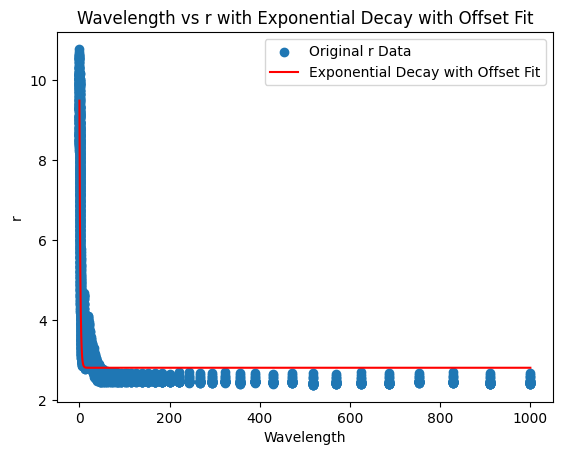

In [132]:
# Assuming 'df' is your DataFrame
wavelength = df['wvl']
r = df['r']

# Define the exponential decay with offset function
def exponential_decay_with_offset(x, a, b, c):
    return a * np.exp(-b * x) + c

# Specify the range for fitting
fit_range = (0, 1000)  # Adjust the range as needed

# Filter data within the specified range
mask = (wavelength >= fit_range[0]) & (wavelength <= fit_range[1])
wavelength_fit = wavelength[mask]
r_fit_data = r[mask]

# Initial guess for the parameters
initial_guess = [max(r_fit_data), 0.001, min(r_fit_data)]  # You may need to adjust the initial guess

# Fit the exponential decay with offset function to the filtered data
params, covariance = curve_fit(exponential_decay_with_offset, wavelength_fit, r_fit_data, p0=initial_guess)

# Extract the fitted parameters
a, b, c = params

# Print or return the coefficients
print("Coefficient 'a':", a)
print("Coefficient 'b':", b)
print("Coefficient 'c':", c)

# Generate values for the exponential decay with offset fit curve
wavelength_fit_curve = np.linspace(min(wavelength_fit), max(wavelength_fit), 1000)
r_fit_curve = exponential_decay_with_offset(wavelength_fit_curve, a, b, c)

# Plot the original 'r' data and the exponential decay with offset fit
plt.scatter(wavelength, r, label='Original r Data')
plt.plot(wavelength_fit_curve, r_fit_curve, color='red', label='Exponential Decay with Offset Fit')
plt.xlabel('Wavelength')
plt.ylabel('r')
plt.legend()
plt.title('Wavelength vs r with Exponential Decay with Offset Fit')
plt.show()


Coefficient 'a': 4.642341327619741
Coefficient 'n': 0.3045346583775604
Coefficient 'c': 1.4306013019265933


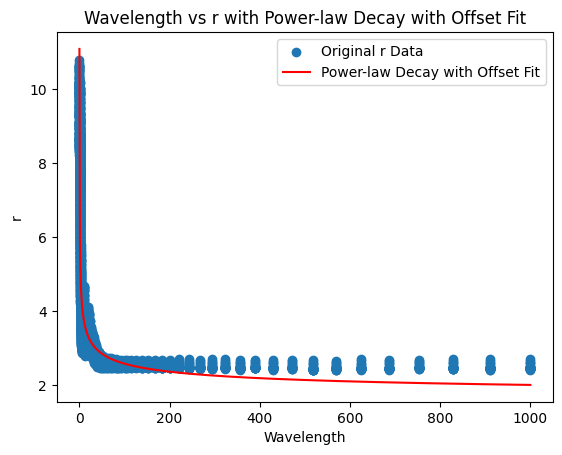

In [134]:
# Assuming 'df' is your DataFrame
wavelength = df['wvl']
r = df['r']

# Define the power-law decay with offset function
def power_law_decay_with_offset(x, a, n, c):
    return a / (x**n) + c

# Specify the range for fitting
fit_range = (0, 1000)  # Adjust the range as needed

# Filter data within the specified range
mask = (wavelength >= fit_range[0]) & (wavelength <= fit_range[1])
wavelength_fit = wavelength[mask]
r_fit_data = r[mask]

# Initial guess for the parameters
initial_guess = [max(r_fit_data), 2.0, min(r_fit_data)]  # You may need to adjust the initial guess

# Fit the power-law decay with offset function to the filtered data
params, covariance = curve_fit(power_law_decay_with_offset, wavelength_fit, r_fit_data, p0=initial_guess)

# Extract the fitted parameters
a, n, c = params

# Print or return the coefficients
print("Coefficient 'a':", a)
print("Coefficient 'n':", n)
print("Coefficient 'c':", c)

# Generate values for the power-law decay with offset fit curve
wavelength_fit_curve = np.linspace(min(wavelength_fit), max(wavelength_fit), 1000)
r_fit_curve = power_law_decay_with_offset(wavelength_fit_curve, a, n, c)

# Plot the original 'r' data and the power-law decay with offset fit
plt.scatter(wavelength, r, label='Original r Data')
plt.plot(wavelength_fit_curve, r_fit_curve, color='red', label='Power-law Decay with Offset Fit')
plt.xlabel('Wavelength')
plt.ylabel('r')
plt.legend()
plt.title('Wavelength vs r with Power-law Decay with Offset Fit')
plt.show()


Coefficient 'a': 4.528080580481109
Coefficient 'n': 0.3227868294317742
Coefficient 'c': 1.5483666062156145


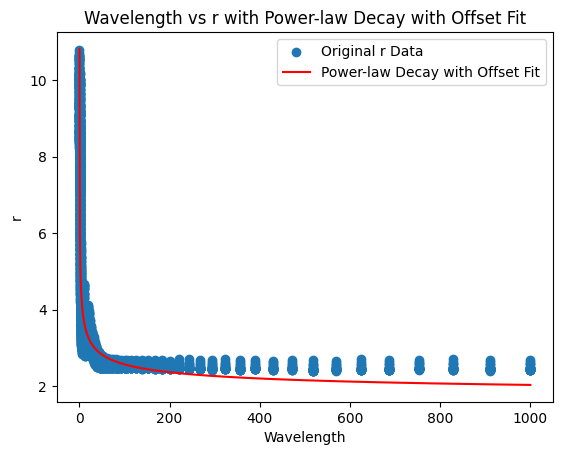

Coefficients Array: [4.52808058 0.32278683 1.54836661]


In [137]:

# Assuming 'df' is your DataFrame
wavelength = df['wvl']
r = df['r']

# Define the power-law decay with offset function
def power_law_decay_with_offset(x, a, n, c):
    return a / (x**n) + c

# Specify the range for fitting
fit_range = (0.1, 1000)  # Adjust the range as needed

# Filter data within the specified range
mask = (wavelength >= fit_range[0]) & (wavelength <= fit_range[1])
wavelength_fit = wavelength[mask]
r_fit_data = r[mask]

# Initial guess for the parameters
initial_guess = [max(r_fit_data), 2.0, min(r_fit_data)]  # You may need to adjust the initial guess

# Fit the power-law decay with offset function to the filtered data
params, covariance = curve_fit(power_law_decay_with_offset, wavelength_fit, r_fit_data, p0=initial_guess)

# Extract the fitted parameters
a, n, c = params

# Store the coefficients in an array
coefficients_array = np.array([a, n, c])

# Print or return the coefficients
print("Coefficient 'a':", a)
print("Coefficient 'n':", n)
print("Coefficient 'c':", c)

# Generate values for the power-law decay with offset fit curve
wavelength_fit_curve = np.linspace(min(wavelength_fit), max(wavelength_fit), 1000)
r_fit_curve = power_law_decay_with_offset(wavelength_fit_curve, a, n, c)

# Plot the original 'r' data and the power-law decay with offset fit
plt.scatter(wavelength, r, label='Original r Data')
plt.plot(wavelength_fit_curve, r_fit_curve, color='red', label='Power-law Decay with Offset Fit')
plt.xlabel('Wavelength')
plt.ylabel('r')
plt.legend()
plt.title('Wavelength vs r with Power-law Decay with Offset Fit')
plt.show()

# Return or use the coefficients array as needed
print("Coefficients Array:", coefficients_array)
